# Glicko-2 Prompt-Completion Pair Statistics

---

In [10]:
!pip install glicko2
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [23]:
# -*- coding: utf-8 -*-
import time
import math
from collections import defaultdict
from datetime import datetime
import pandas as pd
from datasets import load_dataset, IterableDataset, concatenate_datasets, Dataset # Make sure IterableDataset is imported if using streaming
from glicko2 import Player
import re
import datasets
import matplotlib.pyplot as plt
import numpy as np


In [2]:
d = load_dataset("Columbia-NLP/DPO-tldr-summarisation-preferences") # Disable caching
train = d['train']
val = d['validation']
test = d['test']
dataset = train.add_column("sub_reddit", [x['subreddit'] for x in train['other_info']])
dataset_test = val.add_column("sub_reddit", [x['subreddit'] for x in val['other_info']])
dataset_eval = test.add_column("sub_reddit", [x['subreddit'] for x in test['other_info']])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/37.7M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/39.6M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/26.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/50.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/92858 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/33083 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50719 [00:00<?, ? examples/s]

In [48]:
df = dataset.to_pandas()

In [49]:
df['chosen'] = [x[1]['content'] for x in df['chosen']]
d1 = df[['prompt', 'chosen', 'sub_reddit']]
df['reject'] = [x[1]['content'] for x in df['rejected']]
d2 = df[['prompt', 'reject', 'sub_reddit']]
d2 = d2.rename(columns = {'reject': 'chosen'})
df = pd.concat([d1, d2], ignore_index=True)

In [52]:
train_sr = ['AskDocs', 'legaladvice', 'Advice', 'askwomenadvice', 'AskReddit', 'needadvice', 'relationship_advice', 'dating_advice' ]
test_sr = ['running','Cooking']

In [54]:
pair_counts = df.loc[df['sub_reddit'].isin(train_sr)][['prompt', 'chosen']].value_counts()
pair_counts_df = pair_counts.reset_index(name='count')

(array([3.3700e+02, 1.0606e+04, 6.2340e+03, 2.3500e+02, 3.8000e+01,
        1.4100e+02, 8.0000e+00, 9.3000e+01, 1.9000e+01, 3.0000e+00,
        1.1000e+01, 2.3000e+01, 1.0000e+00, 2.4000e+01, 7.0000e+00,
        4.0000e+01, 4.0000e+00, 1.3000e+01, 0.0000e+00, 2.0000e+00,
        7.0000e+00, 9.0000e+00, 4.0000e+00, 2.3000e+01, 2.0000e+00,
        1.7000e+01, 8.0000e+00, 1.3000e+01, 3.0000e+00, 1.8000e+01,
        1.0000e+00, 6.0000e+00, 0.0000e+00, 1.3000e+01, 6.0000e+00,
        8.0000e+00, 9.0000e+00, 1.5000e+01, 5.0000e+00, 5.0000e+00,
        5.0000e+00, 1.9000e+01, 7.0000e+00, 2.4000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.]),
 <BarContainer object of 50 a

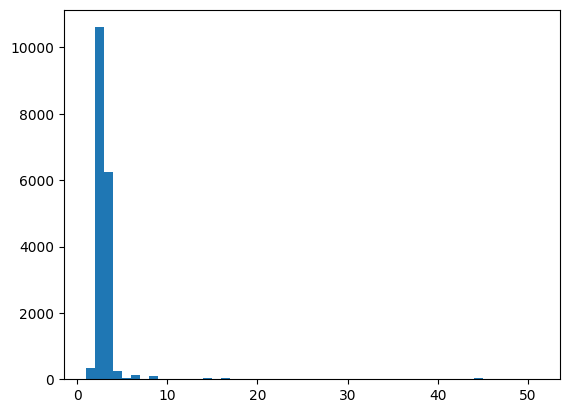

In [55]:
plt.hist(pair_counts_df['count'], bins = range(1, 52))

In [ ]:
df['sub_reddit'].unique()

array(['AskReddit', 'tifu', 'relationships', 'dating_advice', 'Advice',
       'jobs', 'cats', 'travel', 'personalfinance', 'relationship_advice',
       'askwomenadvice', 'Pets', 'loseit', 'Dogtraining', 'Cooking',
       'legaladvice', 'running', 'offmychest', 'Parenting', 'dogs',
       'BreakUps', 'self', 'weddingplanning', 'AskDocs', 'needadvice',
       'books', 'GetMotivated', 'pettyrevenge', 'college'], dtype=object)

In [ ]:
train_sr = ['AskDocs', 'legaladvice', 'Advice', 'askwomenadvice', 'AskReddit', 'needadvice', 'relationship_advice', 'dating_advice' ]
test_sr = ['running','Cooking']
train_df = df.loc[ df['sub_reddit'].isin(train_sr)]
test_df = df.loc[ df['sub_reddit'].isin(test_sr)]
dataset = Dataset.from_pandas(train_df)

In [ ]:
train_df.describe()

,score_chosen,score_rejected
count,27000.0,27000.0
mean,10.0,1.0
std,0.0,0.0
min,10.0,1.0
25%,10.0,1.0
50%,10.0,1.0
75%,10.0,1.0
max,10.0,1.0


In [ ]:
test_df.describe()

,score_chosen,score_rejected
count,524.0,524.0
mean,10.0,1.0
std,0.0,0.0
min,10.0,1.0
25%,10.0,1.0
50%,10.0,1.0
75%,10.0,1.0
max,10.0,1.0


In [ ]:
test_df['prompt'].iloc[500]

'You are an AI assistant good at summarizing reddit post. Your task is to summarize the following post from subreddit r/running without including unimportant or irrelevant details.\nA good summary is both precise and concise.\n\nPost:\nI\'m totally stoked! I knew I\'d probably be taking in some extra calories over the holiday so I talked myself into it. Prior to this my farthest distance was 10 miles. It was totally unplanned and was a great example of overcoming that voice in your head that says "Can\'t". Here\'s how the conversation went:\n\nWife as I\'m walking out the door: How far are you running?\n\nPositive Me: At least 5 miles\n\nWife: Cool.\n\n(After a quick stretch, I start running)\n\nNegative me (.25 miles): Man, I\'m not feeling it today. I think I\'ll just run 2-3 and call it a day.\n\nPositive me: Seriously? Just for your whining, now you\'re running AT LEAST 8 miles.\n\nNegative me: What? We\'ll see.\n\nPositive me (.5 miles): Nope. No argument. Man up.\n\n...(running c

In [ ]:
dataset

Dataset({
    features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected', 'other_info', 'sub_reddit', '__index_level_0__'],
    num_rows: 27000
})

In [ ]:
start_time = time.time()

In [ ]:
p2i = {}
i2p = {}
a2i = {}
i2a = {}
p = 0
a = 0
for row in dataset:
    if row['prompt'] not in p2i:
        p2i[row['prompt']] = p
        i2p[p] = row['prompt']
        p+=1
    if row['chosen'][1]['content'] not in a2i:
        a2i[row['chosen'][1]['content']] = a
        i2a[a] = row['chosen'][1]['content']
        a += 1
    if row['rejected'][1]['content'] not in a2i:
        a2i[row['rejected'][1]['content']] = a
        i2a[a] = row['rejected'][1]['content']
        a += 1

In [ ]:
# --- 3. Initialize Player Storage ---
print("Initializing player storage...")
# Use the Player class defined above
players = {} # Dictionary to store author_id -> Player object instance
all_known_players = set() # Keep track of all players ever encountered

def get_player(author_id):
    """Gets or creates a Player object for a valid author ID."""
    # Check specifically against None and handle empty strings if necessary
    if author_id is not None and author_id.strip() != '' and author_id.lower() != '[deleted]':
        if author_id not in players:
            players[author_id] = Player() # Use the provided Player class
            # print(f"Created player: {author_id}") # Optional: for debugging
        all_known_players.add(author_id) # Track all valid players encountered
        return players.get(author_id)
    return None # Return None for invalid authors

Initializing player storage...


In [ ]:
# --- 4. Process Matches and Group by Period ---
print("Processing matches and grouping by period...")
matches_by_period = defaultdict(lambda: defaultdict(lambda: {'ratings': [], 'rds': [], 'outcomes': []}))
processed_count = 0
# max_rows_to_process = 100000 # Optional: Limit rows for testing even without streaming
skipped_same_author = 0
skipped_deleted = 0
skipped_fetch_error = 0
max_rows_to_process = 5000
# Now iterate directly over the loaded dataset (which acts like a list/dict)
try:
    for i, row in enumerate(dataset):
        processed_count += 1
        # if processed_count > max_rows_to_process: # Apply optional limit if defined
        #      print(f"Reached processing limit of {max_rows_to_process} rows.")
        #      break

        # Extract data
        p_ind = p2i[row.get('prompt')]
        # Player j won
        author_j = str((p_ind, a2i[row.get('chosen')[1]['content']]))
        author_k = str((p_ind, a2i[row.get('rejected')[1]['content']]))

        if author_j is None or author_k is None:
            skipped_fetch_error += 1
            continue
        if author_j == author_k:
            skipped_same_author += 1
            continue

        player_j = get_player(author_j)
        player_k = get_player(author_k)

        if player_j is None or player_k is None:
            skipped_deleted += 1
            continue
        period = '0'
        rating_j_current = player_j.rating
        rd_j_current = player_j.rd
        rating_k_current = player_k.rating
        rd_k_current = player_k.rd

        outcome_for_j = 1.0
        outcome_for_k = 0.0

        matches_by_period[period][author_j]['ratings'].append(rating_k_current)
        matches_by_period[period][author_j]['rds'].append(rd_k_current)
        matches_by_period[period][author_j]['outcomes'].append(outcome_for_j)

        matches_by_period[period][author_k]['ratings'].append(rating_j_current)
        matches_by_period[period][author_k]['rds'].append(rd_j_current)
        matches_by_period[period][author_k]['outcomes'].append(outcome_for_k)

        if processed_count % 20000 == 0: # Adjust print frequency as needed
            print(f"Gathered data for {processed_count}/{len(dataset)} rows...")

except Exception as e:
     print(f"An error occurred during data iteration at row {processed_count}: {e}")


print(f"\n--- Data Gathering Summary ---")
# ... [Summary print statements remain the same] ...
print(f"Total rows processed: {processed_count}")
print(f"Matches skipped (same author): {skipped_same_author}")
print(f"Matches skipped (deleted/invalid author): {skipped_deleted}")
print(f"Matches skipped (data fetch error): {skipped_fetch_error}")
print(f"Total unique valid authors encountered: {len(all_known_players)}")
print(f"Number of rating periods found: {len(matches_by_period)}")


Processing matches and grouping by period...
Gathered data for 20000/27000 rows...

--- Data Gathering Summary ---
Total rows processed: 27000
Matches skipped (same author): 6
Matches skipped (deleted/invalid author): 0
Matches skipped (data fetch error): 0
Total unique valid authors encountered: 18090
Number of rating periods found: 1


In [ ]:
# --- 5. Run Glicko-2 Updates Period by Period ---
print("\nUpdating ratings period by period...")
# ... [Rating update loop remains the same as previous response] ...
sorted_periods = sorted(matches_by_period.keys())

for period in sorted_periods:
    print(f"Processing period: {period}")
    players_in_period = set(matches_by_period[period].keys())

    # Identify players who *didn't* compete in this period but existed before
    inactive_players_in_period = all_known_players - players_in_period

    # Apply Step 6: Update RD for inactive players
    inactive_update_count = 0
    for author_id in inactive_players_in_period:
        player = players.get(author_id)
        if player: # Should always exist if in all_known_players
             try:
                 player.did_not_compete()
                 inactive_update_count += 1
             except Exception as e:
                 print(f"Error calling did_not_compete for {author_id} in period {period}: {e}")

    # Apply Steps 3-5: Update rating, RD, vol for active players
    updates_count = 0
    for author_id in players_in_period:
        player = players.get(author_id)
        if not player: continue # Should not happen if key exists, but safe check

        period_data = matches_by_period[period][author_id]
        opponent_ratings = period_data['ratings']
        opponent_rds = period_data['rds']
        outcomes = period_data['outcomes']

        # Ensure we have opponents before calling update
        if opponent_ratings:
            try:
                player.update_player(opponent_ratings, opponent_rds, outcomes)
                updates_count += 1
            except OverflowError:
                 print(f"OverflowError encountered updating player {author_id} in period {period}. Skipping update.")
                 # This can happen with extreme rating differences or RDs. Might indicate need for parameter tuning or data cleaning.
                 # Consider logging player state: player.rating, player.rd, player.vol and opponent data
            except FloatingPointError as fpe:
                print(f"FloatingPointError encountered updating player {author_id} in period {period}: {fpe}. Skipping update.")
            except Exception as e:
                 print(f"Error updating player {author_id} in period {period}: {e}")


    print(f"-> Completed updates for {updates_count} active players. Applied inactivity update for {inactive_update_count} players.")


print("Rating updates complete.")





Updating ratings period by period...
Processing period: 0
-> Completed updates for 18090 active players. Applied inactivity update for 0 players.
Rating updates complete.


In [ ]:
# --- 6. Display Results ---
print("\n--- Final Glicko-2 Ratings for Authors ---")
# ... [Result display remains the same as previous response] ...
author_ratings = []
skipped_final_rating = 0
for author_id, player in players.items():
    try:
        # Add check for NaN/Inf before appending
        rating_val = player.rating
        rd_val = player.rd
        vol_val = player.vol
        if not (math.isfinite(rating_val) and math.isfinite(rd_val) and math.isfinite(vol_val)):
            print(f"Warning: Non-finite values for player {author_id}. Rating={rating_val}, RD={rd_val}, Vol={vol_val}. Skipping.")
            skipped_final_rating += 1
            continue

        author_ratings.append({
            "author": author_id,
            "rating": rating_val, # Uses the property getter
            "deviation (RD)": rd_val, # Uses the property getter
            "volatility": vol_val
        })
    except Exception as e:
        print(f"Error retrieving final rating for {author_id}: {e}")
        skipped_final_rating += 1


if skipped_final_rating > 0:
    print(f"\nNote: Skipped retrieving final ratings for {skipped_final_rating} authors due to errors or non-finite values.")

# Sort by rating descending for readability
results_df = pd.DataFrame(author_ratings)

if not results_df.empty:
    # Ensure columns are numeric before sorting
    results_df['rating'] = pd.to_numeric(results_df['rating'], errors='coerce')
    results_df['deviation (RD)'] = pd.to_numeric(results_df['deviation (RD)'], errors='coerce')
    results_df['volatility'] = pd.to_numeric(results_df['volatility'], errors='coerce')
    results_df.dropna(subset=['rating'], inplace=True) # Remove rows where rating became NaN

if not results_df.empty:
    results_df = results_df.sort_values(by="rating", ascending=False)

    # Display top N and bottom N for brevity, or the whole list
    pd.set_option('display.max_rows', 100) # Show more rows if needed
    print(f"Displaying top {min(20, len(results_df))} and bottom {min(10, len(results_df))} authors:")
    print(results_df.head(20))
    if len(results_df) > 30:
        print("...")
        print(results_df.tail(10))
    elif len(results_df) > 20:
         print("...") # Just indicate truncation if list is moderately long
else:
    print("No valid final ratings could be generated or displayed.")




--- Final Glicko-2 Ratings for Authors ---
Displaying top 20 and bottom 10 authors:
              author       rating  deviation (RD)  volatility
10493  (2591, 10490)  1994.016832       77.239280    0.062963
14720  (3604, 14715)  1992.220354       79.937647    0.062522
4312    (1075, 4312)  1985.889097       88.796359    0.061555
5736    (1426, 5736)  1985.889097       88.796359    0.061555
10523  (2598, 10520)  1983.814762       91.512517    0.061355
11984  (2952, 11980)  1978.783432       97.787750    0.061001
3898     (971, 3898)  1978.783432       97.787750    0.061001
3896     (971, 3896)  1978.783432       97.787750    0.061001
12833  (3156, 12829)  1975.691675      101.451559    0.060846
12835  (3156, 12831)  1975.691675      101.451559    0.060846
7093    (1763, 7093)  1972.088889      105.560665    0.060706
10495  (2591, 10492)  1972.083424       76.398758    0.062802
888       (222, 888)  1968.805377       79.006998    0.062377
11598  (2856, 11594)  1963.654207       82.9401

In [ ]:
# Convert to DataFrame
results_df = pd.DataFrame(author_ratings)

# --- Normalization Step ---
if not results_df.empty:
    print(f"\nNormalizing {len(results_df)} valid results...")
    # Min-Max Normalization (scaling to [0, 1])

    # Rating
    r_min = results_df['rating'].min()
    r_max = results_df['rating'].max()
    if (r_max - r_min) != 0:
        results_df['rating_norm'] = (results_df['rating'] - r_min) / (r_max - r_min)
    else:
        results_df['rating_norm'] = 0.5 # Assign midpoint if all values are the same

    # Deviation (RD)
    rd_min = results_df['deviation (RD)'].min()
    rd_max = results_df['deviation (RD)'].max()
    if (rd_max - rd_min) != 0:
        results_df['rd_norm'] = (results_df['deviation (RD)'] - rd_min) / (rd_max - rd_min)
    else:
        results_df['rd_norm'] = 0.5

    # Volatility
    v_min = results_df['volatility'].min()
    v_max = results_df['volatility'].max()
    if (v_max - v_min) != 0:
        results_df['volatility_norm'] = (results_df['volatility'] - v_min) / (v_max - v_min)
    else:
        results_df['volatility_norm'] = 0.5

    # Sort by original rating
    results_df = results_df.sort_values(by="rating", ascending=False)

    # Display selected columns including normalized ones
    pd.set_option('display.max_rows', 100)
    pd.set_option('display.width', 120) # Adjust width for better display
    print(f"\nDisplaying top {min(20, len(results_df))} authors (incl. normalized scores):")
    # Select columns to display
    display_cols = ['author', 'rating', 'rating_norm', 'deviation (RD)', 'rd_norm', 'volatility', 'volatility_norm']
    print(results_df[display_cols].head(20).round(4)) # Round for display

    if len(results_df) > 20:
        print("...")
        print(f"\nDisplaying bottom {min(10, len(results_df))} authors (incl. normalized scores):")
        print(results_df[display_cols].tail(min(10, max(0, len(results_df)))).round(4))

else:
    print("No valid final ratings could be generated or displayed.")
df = results_df
auth = df['author'].apply(lambda x: re.sub('[^A-Za-z0-9,]', '', str(x))).str.split(',')
prompts = auth.apply(lambda x: i2p[int(x[0])])
answers = auth.apply(lambda x: i2a[int(x[1])])
df['question'] = prompts
df['answer'] = answers

# Optionally, save to CSV (including normalized columns)
try:
    if not df.empty:
        df.to_csv("author_ratings_normalized.csv", index=False, float_format='%.6f')
        print("\nResults saved to author_ratings_normalized.csv")
except Exception as e:
    print(f"\nError saving results to CSV: {e}")
end_time = time.time()
print(f"\nCurrent time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total execution time: {end_time - start_time:.2f} seconds")


Normalizing 18090 valid results...

Displaying top 20 authors (incl. normalized scores):
              author     rating  rating_norm  deviation (RD)  rd_norm  volatility  volatility_norm
10493  (2591, 10490)  1994.0168       1.0000         77.2393   0.0686      0.0630           0.3168
14720  (3604, 14715)  1992.2204       0.9982         79.9376   0.0804      0.0625           0.2709
4312    (1075, 4312)  1985.8891       0.9918         88.7964   0.1191      0.0616           0.1701
5736    (1426, 5736)  1985.8891       0.9918         88.7964   0.1191      0.0616           0.1701
10523  (2598, 10520)  1983.8148       0.9898         91.5125   0.1310      0.0614           0.1493
11984  (2952, 11980)  1978.7834       0.9847         97.7877   0.1584      0.0610           0.1125
3898     (971, 3898)  1978.7834       0.9847         97.7877   0.1584      0.0610           0.1125
3896     (971, 3896)  1978.7834       0.9847         97.7877   0.1584      0.0610           0.1125
12833  (3156, 12829

In [ ]:
# Save dictionaries that map text to indices
import pickle
def save_dictionary(dictionary, filename):
    """
    Save a dictionary to a file using pickle.

    Args:
        dictionary (dict): The dictionary to save
        filename (str): The name of the file to save to
    """
    with open(filename, 'wb') as file:
        pickle.dump(dictionary, file)
    print(f"Dictionary saved to {filename}")

In [ ]:
save_dictionary(p2i, 'p2i')
save_dictionary(i2a, 'i2a')
save_dictionary(i2p, 'i2p')
save_dictionary(a2i, 'a2i')

Dictionary saved to p2i
Dictionary saved to i2a
Dictionary saved to i2p
Dictionary saved to a2i


In [ ]:
results_df.describe()

,rating,deviation (RD),volatility,rating_norm,rd_norm,volatility_norm
count,18090.000000,18090.000000,18090.000000,18090.000000,18090.000000,18090.000000
mean,1498.172204,240.171256,0.060013,0.502795,0.780802,0.009662
std,213.965473,26.584478,0.000150,0.214553,0.116202,0.015639
min,996.753739,61.541146,0.059920,0.000000,0.000000,0.000000
25%,1252.681917,227.735415,0.059997,0.256631,0.726444,0.007972
50%,1500.000000,253.404596,0.060003,0.504627,0.838645,0.008600
75%,1747.318083,253.404608,0.060003,0.752624,0.838645,0.008600
max,1994.016832,290.318965,0.069525,1.000000,1.000000,1.000000
